## ANEXO 4: Implementación de modelos de Machine Learning

In [ ]:
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# semilla a utilizar en los splits train/test
SEED = 0

### Carga y preprocesamiento de datos

In [ ]:
# carga de datos
df_full = pd.read_pickle(r"..\data\short.pkl")

In [ ]:
X = df_full.iloc[:, 6:-1]
y = df_full["HIJO_RECIENTE"]

In [ ]:
# one-hot encoding de columnas que son strings
string_columns = ["REGION", "PARENTESCO", "PUEBLO_ORIGINARIO", "LUGAR_NAC", "LUGAR_NAC_PAIS"]
for column_name in string_columns:
    dummies = pd.get_dummies(X[column_name])
    dummies.columns = dummies.columns.map(lambda x: column_name + " IS " + str(x))
    X = X.join(dummies)

# eliminamos las columnas que son strings
X.drop(columns=string_columns, inplace=True)

In [ ]:
# normalizar columnas numéricas
normalize_columns = ["CENTROIDE_X_DIST", "CENTROIDE_Y_DIST", "POBLACION_DIST", "SUPERFICIE_DIST", "DENSIDAD_DIST", "EDAD", "ANOS_ESCOLARIDAD", "TOTAL_HIJOS"]
for column_name in normalize_columns:
    X[column_name] = (X[column_name]-X[column_name].mean())/X[column_name].std()

In [ ]:
# split para los tests finales (una vez ajustados los hiperparámetros)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y, random_state=SEED)

### Implementación de métodos para entrenar y testear

In [ ]:
# resampler que recibe como parámetro un tipo (over/under/none)
# y hace el sampling adecuado; se puede usar con GridSearchCV
class resampler:

    def __init__(self, **params):

        self.set_params(**params)

    def set_params(self, **params):

        type = params.get("type")
        random_state = params.get("random_state")

        if type == "over": self.sampler = RandomOverSampler(random_state=random_state)
        elif type == "under": self.sampler = RandomUnderSampler(random_state=random_state)
        else: self.sampler = None

    def fit_resample(self, X, y):

        if self.sampler is None: return (X, y)
        return self.sampler.fit_resample(X, y)

# función que recibe un modelo y un diccionario de parámetros, y
# retorna un clasificador que realiza grid search con k-fold cross
# validation, y con over/under/no sampling en cada iteración sobre
# los datos de entrenamiento.
def reSampledGridSearchCV(estimator, param_grid, sampling=["over", "under", "none"], k=5, seed=SEED):

    # crear el pipeline
    model = Pipeline([
        ("resampler", resampler(random_state=seed)),
        ("estimator", estimator)
    ])

    # rehacer el diccionario
    params = {"resampler__type": sampling}
    for key, value in param_grid.items():
        params["estimator__" + key] = value

    # retorna el clasificador
    return GridSearchCV(
        model,
        param_grid=params,
        cv=k,
        scoring="f1",
        refit=True,
        n_jobs=2  # corre 2 procesos en paralelo, cambiar a 1 si se pega el pc
    )


In [ ]:
# entrena un modelo de GridSearchCV usando X_train e y_train, y lo
# testea usando X_test e y_test. imprime los parámetros escogidos,
# el mejor F1 obtenido en entrenamiento y el classification report
# con los datos de testeo
def fitAndTest(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Parámetros escogidos: {clf.best_params_}")
    print(f"Mejor F1 en entrenamiento: {clf.best_score_:.2f}")
    print(f"Puntaje F1 en testeo: {f1_score(y_test, y_pred):.2f}")
    print("Classification report: ")
    print(classification_report(y_test, y_pred))

### Selección de hiperparámetros y comparación de métricas

In [ ]:
# clasificador dummy (usado como base)

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(f"Puntaje F1 en testeo: {f1_score(y_test, dummy_pred):.2f}")
print("Classification report: ")
print(classification_report(y_test, dummy_pred))

Puntaje F1 en testeo: 0.06
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94   1228561
           1       0.06      0.06      0.06     82737

    accuracy                           0.88   1311298
   macro avg       0.50      0.50      0.50   1311298
weighted avg       0.88      0.88      0.88   1311298



In [ ]:
# decision tree

tree_params = {"max_depth": [3, 5, 7, 10], "criterion": ["gini", "entropy"]}

tree_clf = reSampledGridSearchCV(DecisionTreeClassifier(), tree_params)
fitAndTest(tree_clf)

Parámetros escogidos: {'estimator__criterion': 'gini', 'estimator__max_depth': 7, 'resampler__type': 'over'}
Mejor F1 en entrenamiento: 0.22
Puntaje F1 en testeo: 0.22
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.68      0.80   1228561
           1       0.13      0.72      0.22     82737

    accuracy                           0.68   1311298
   macro avg       0.55      0.70      0.51   1311298
weighted avg       0.92      0.68      0.76   1311298



In [ ]:
# naive bayes

nb_clf = reSampledGridSearchCV(GaussianNB(), {})
fitAndTest(nb_clf)

Parámetros escogidos: {'resampler__type': 'under'}
Mejor F1 en entrenamiento: 0.17
Puntaje F1 en testeo: 0.17
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.45      0.61   1228561
           1       0.09      0.84      0.17     82737

    accuracy                           0.47   1311298
   macro avg       0.53      0.64      0.39   1311298
weighted avg       0.92      0.47      0.58   1311298



In [ ]:
# random forest
# usamos los hiperparámetros escogidos en decision tree
# para no hacer búsquedas redundantes con gridsearch

rf_params = {"n_estimators": [50, 100, 200, 300, 400, 500, 1000]}
rf_sampling = ["over", "under"]

rf_clf = reSampledGridSearchCV(
    RandomForestClassifier(max_depth=7, criterion="gini"),
    rf_params,
    sampling=rf_sampling
)
fitAndTest(rf_clf)

Parámetros escogidos: {'estimator__n_estimators': 100, 'resampler__type': 'under'}
Mejor F1 en entrenamiento: 0.20
Puntaje F1 en testeo: 0.21
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.59      0.74   1228561
           1       0.12      0.81      0.21     82737

    accuracy                           0.61   1311298
   macro avg       0.55      0.70      0.47   1311298
weighted avg       0.92      0.61      0.71   1311298



In [ ]:
# gradient boosting
# usamos los hiperparámetros escogidos en random forest
# para no hacer búsquedas redundantes con gridsearch

gboost_params = {"learning_rate": [0.1, 0.25, 0.5, 0.75]}
gboost_sampling = ["over", "under"]

gboost_clf = reSampledGridSearchCV(
    GradientBoostingClassifier(max_depth=7, n_estimators=100),
    gboost_params,
    sampling=gboost_sampling
)
fitAndTest(gboost_clf)

Parámetros escogidos: {'estimator__learning_rate': 0.25, 'resampler__type': 'over'}
Mejor F1 en entrenamiento: 0.23
Puntaje F1 en testeo: 0.25
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.68      0.81   1228561
           1       0.15      0.80      0.25     82737

    accuracy                           0.69   1311298
   macro avg       0.56      0.74      0.53   1311298
weighted avg       0.93      0.69      0.77   1311298



In [ ]:
# stochastic gradient descent
sgd_params = {"loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"]}
sgd_sampling = ["over", "under"]

sgd_clf = reSampledGridSearchCV(
    SGDClassifier(),
    sgd_params,
    sampling=sgd_sampling
)
fitAndTest(sgd_clf)

Parámetros escogidos: {'estimator__loss': 'log_loss', 'resampler__type': 'over'}
Mejor F1 en entrenamiento: 0.22
Puntaje F1 en testeo: 0.22
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.69      0.81   1228561
           1       0.13      0.68      0.22     82737

    accuracy                           0.69   1311298
   macro avg       0.55      0.69      0.51   1311298
weighted avg       0.92      0.69      0.77   1311298



### Guardado de objetos mediante `pickle`

In [ ]:
# función para probar si los objetos se guardan correctamente
def probar_resultados(clf):

    y_pred = clf.predict(X_test)

    print("Classification report: ")
    print(classification_report(y_test, y_pred))

In [ ]:
# guardar objetos creados y verificar funcionamiento
with open('../data/clfs/dummy.pkl', 'wb') as file:
    pickle.dump(dummy_clf, file)

with open('../data/clfs/dummy.pkl', 'rb') as file:
    dummy_object = pickle.load(file)

probar_resultados(dummy_object)

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94   1228561
           1       0.06      0.06      0.06     82737

    accuracy                           0.88   1311298
   macro avg       0.50      0.50      0.50   1311298
weighted avg       0.88      0.88      0.88   1311298



In [ ]:
with open('../data/clfs/tree.pkl', 'wb') as file:
    pickle.dump(tree_clf, file)


with open('../data/clfs/tree.pkl', 'rb') as file:
    tree_object = pickle.load(file)
probar_resultados(tree_object)

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.69      0.80   1228561
           1       0.13      0.71      0.22     82737

    accuracy                           0.69   1311298
   macro avg       0.55      0.70      0.51   1311298
weighted avg       0.92      0.69      0.77   1311298



In [ ]:
with open('../data/clfs/naive.pkl', 'wb') as file:
    pickle.dump(nb_clf, file)

with open('../data/clfs/naive.pkl', 'rb') as file:
    naive_object = pickle.load(file)

probar_resultados(naive_object)

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.47      0.63   1228561
           1       0.09      0.83      0.17     82737

    accuracy                           0.49   1311298
   macro avg       0.54      0.65      0.40   1311298
weighted avg       0.92      0.49      0.60   1311298



In [ ]:
with open('../data/clfs/rf.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)

with open('../data/clfs/rf.pkl', 'rb') as file:
    rf_object = pickle.load(file)

probar_resultados(rf_object)

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.57      0.72   1228561
           1       0.11      0.83      0.20     82737

    accuracy                           0.59   1311298
   macro avg       0.55      0.70      0.46   1311298
weighted avg       0.93      0.59      0.69   1311298



In [ ]:
with open('../data/clfs/gboost.pkl', 'wb') as file:
    pickle.dump(gboost_clf, file)

with open('../data/clfs/gboost.pkl', 'rb') as file:
    gboost_object = pickle.load(file)

probar_resultados(gboost_object)

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.67      0.80   1228561
           1       0.14      0.77      0.23     82737

    accuracy                           0.68   1311298
   macro avg       0.56      0.72      0.51   1311298
weighted avg       0.92      0.68      0.76   1311298



In [ ]:
with open('../data/clfs/sgd.pkl', 'wb') as file:
    pickle.dump(sgd_clf, file)

with open('../data/clfs/sgd.pkl', 'rb') as file:
    sgd_object = pickle.load(file)

probar_resultados(sgd_object)

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.68      0.80   1228561
           1       0.13      0.70      0.22     82737

    accuracy                           0.68   1311298
   macro avg       0.55      0.69      0.51   1311298
weighted avg       0.92      0.68      0.76   1311298



### Análisis cualitativo de modelos

In [ ]:
# función para generar curva ROC de un modelo
def generateRocCurve(clf, model_name, X_test=X_test, y_test=y_test):

    y_predict = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_area = roc_auc_score(y_test, y_predict)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.fill_between(fpr, tpr, color="lightsteelblue")

    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    fig.suptitle(f"Curva ROC para {model_name}")
    ax.set_title(f"Área bajo la curva: {roc_area:.3f}", fontdict={"size":10})

    plt.show()


In [ ]:
# función para generar matriz de confusión de un modelo
def generateConfusionMatrix(clf, model_name, X_test=X_test, y_test=y_test):

    y_predict = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predict, normalize="true")

    fig, ax = plt.subplots()
    ax = sns.heatmap(cm, annot=True, vmin=0, vmax=1, cmap="viridis")
    fig.suptitle(f"Matriz de confusión para {model_name}")
    ax.set_xlabel("Clase predicha")
    ax.set_ylabel("Clase real")

    plt.show()

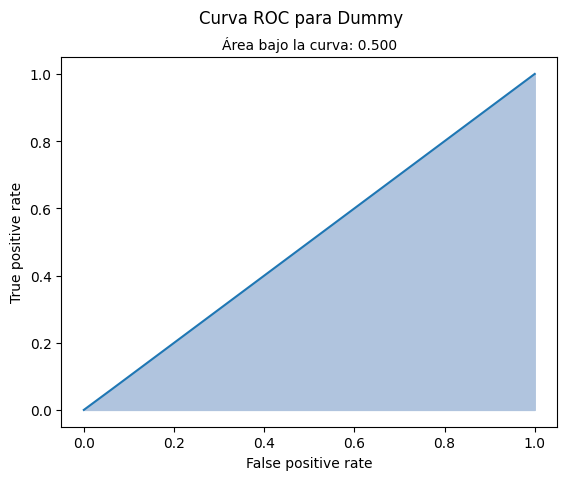

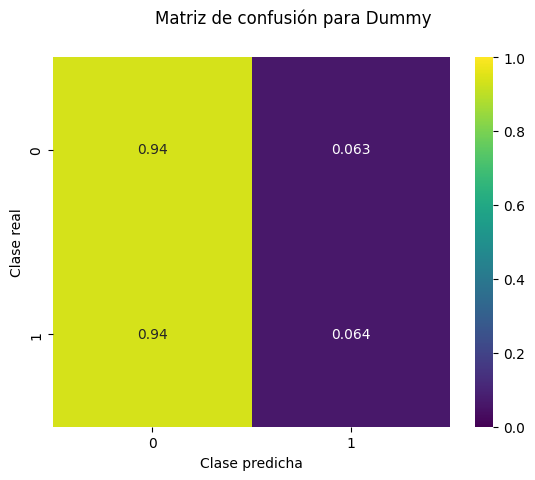

In [ ]:
generateRocCurve(dummy_clf, "Dummy")
generateConfusionMatrix(dummy_clf, "Dummy")

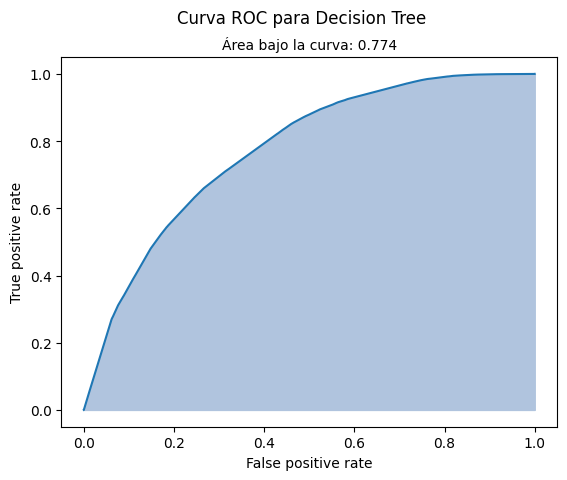

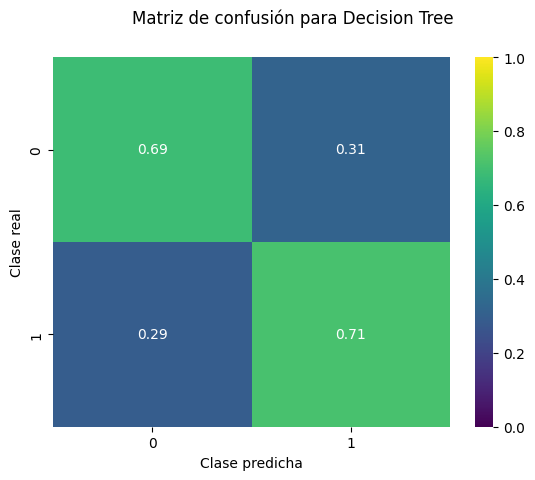

In [ ]:
generateRocCurve(tree_clf, "Decision Tree")
generateConfusionMatrix(tree_clf, "Decision Tree")

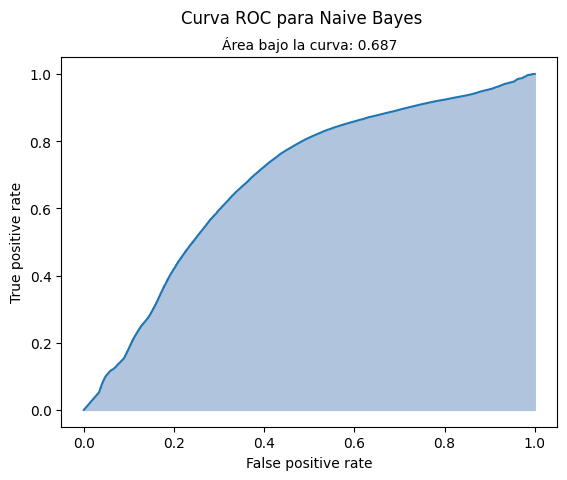

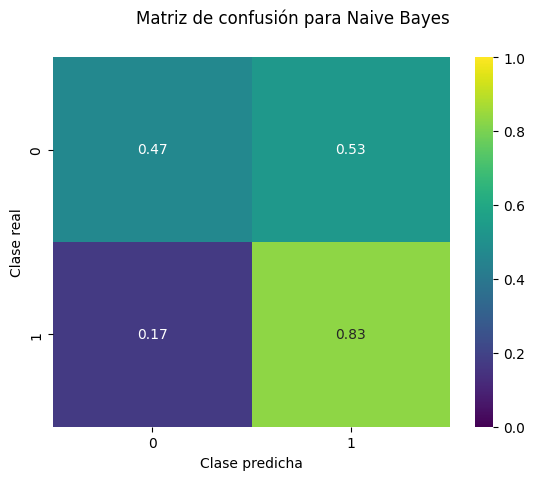

In [ ]:
generateRocCurve(nb_clf, "Naive Bayes")
generateConfusionMatrix(nb_clf, "Naive Bayes")

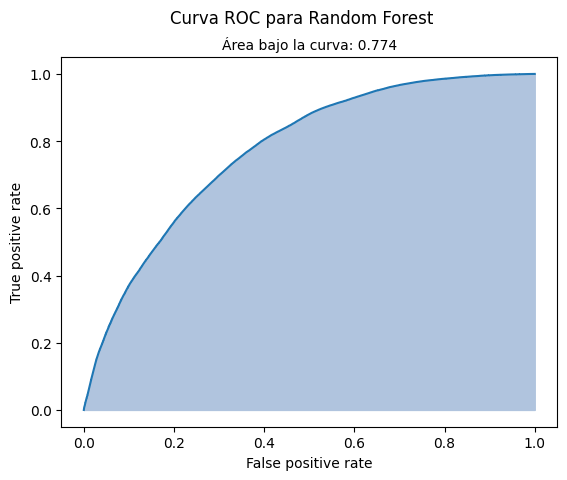

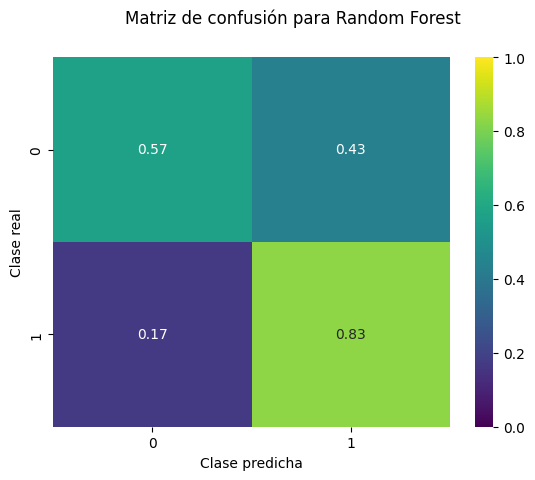

In [ ]:
generateRocCurve(rf_clf, "Random Forest")
generateConfusionMatrix(rf_clf, "Random Forest")

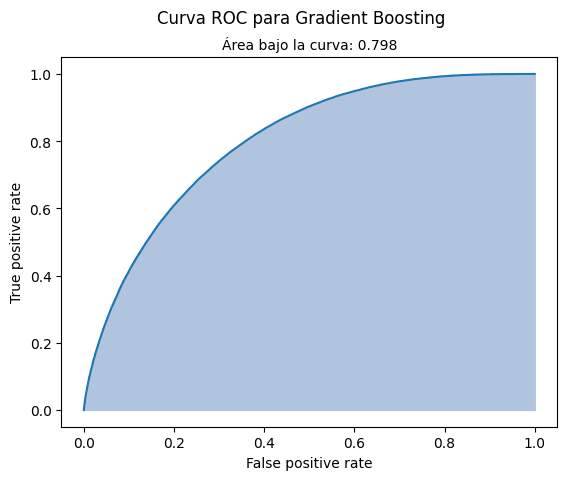

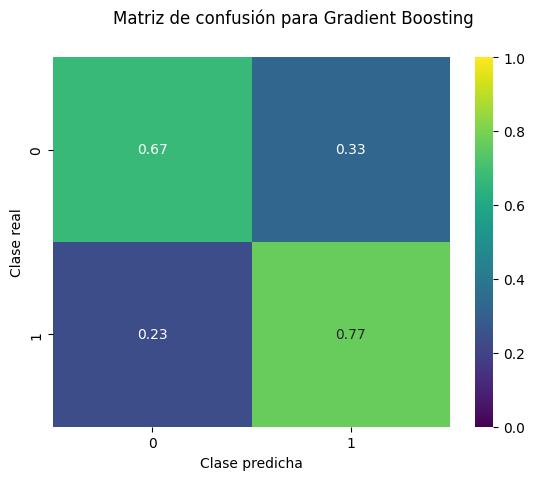

In [ ]:
generateRocCurve(gboost_clf, "Gradient Boosting")
generateConfusionMatrix(gboost_clf, "Gradient Boosting")

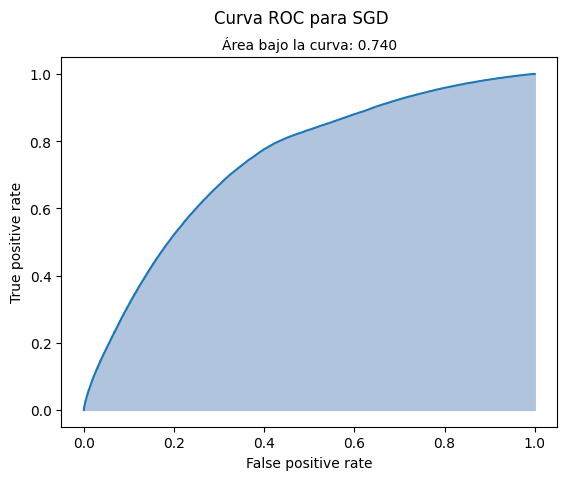

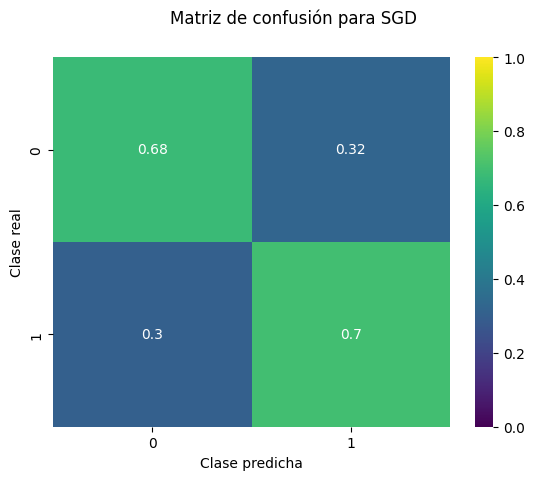

In [ ]:
generateRocCurve(sgd_clf, "SGD")
generateConfusionMatrix(sgd_clf, "SGD")